Link Video		    : [UAS Deep Learning No 2 (Gabriella Clairine - 2702302183)](https://youtu.be/gfGmi7M9jos)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from skimage.metrics import structural_similarity as ssim

# A. EDA

In [ ]:
# Folder tempat gambar disimpan
data_dir = "dataset"

# Membuat list semua file gambar (jpg, jpeg, png) dari folder dataset
image_files = [
    f for f in os.listdir(data_dir) 
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))  # hanya ambil file gambar
]

In [39]:
# Ekstrak label dari nama file
def extract_label(filename):
    return filename.split()[0].lower()

labels = [extract_label(f) for f in image_files]

# Path lengkap untuk setiap file gambar (misal: "dataset/kirmizi 001.jpg")
filepaths = [os.path.join(data_dir, f) for f in image_files]

# Jumlah total gambar dan label unik yang ditemukan
print(f"Found {len(image_files)} images. Labels: {set(labels)}")

Found 1074 images. Labels: {'siirt', 'kirmizi'}


In [4]:
df = pd.DataFrame({
    'filepath': filepaths,
    'filename': image_files,
    'label': labels
})

### Jumlah Gambar per Label

C:\Users\User\AppData\Local\Temp\ipykernel_36448\2313361455.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="pastel")


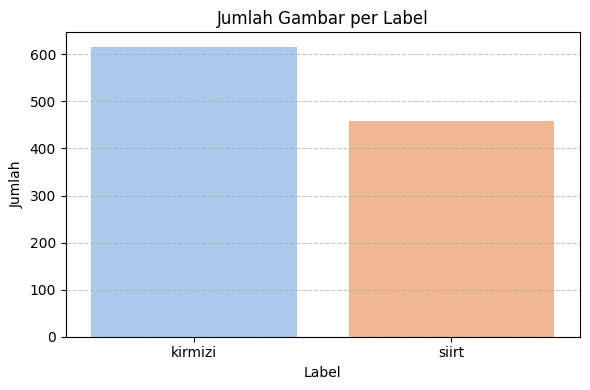

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label", palette="pastel")
plt.title("Jumlah Gambar per Label")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- kirmizi memiliki lebih dari 600 gambar
- siirt memiliki sekitar 450 gambar

Dataset tidak sepenuhnya seimbang, namun perbedaannya masih dalam batas wajar

### Ukuran Gambar

In [ ]:
# Cek ukuran dari setiap gambar di dataset
img_sizes = []
for path in df["filepath"]:
    with Image.open(path) as img:
        img_sizes.append(img.size)  # simpan ukuran (width, height)

# Hitung frekuensi dari setiap ukuran gambar
size_counts = pd.Series(img_sizes).value_counts()

print("Ukuran gambar unik:")
print(size_counts)

Ukuran gambar unik:
(600, 600)    1074
Name: count, dtype: int64


Seluruh gambar dalam dataset berukuran 600×600 pixel dan tidak ada variasi ukuran gambar

### Visualisasi Contoh Gambar per Kelas

In [ ]:
# Fungsi untuk menampilkan contoh gambar dari label tertentu
def show_samples(label_name, n=4):
    # Ambil n file gambar pertama dengan label yang diminta
    sample_files = df[df["label"] == label_name]["filepath"].iloc[:n]
    plt.figure(figsize=(12, 3))
    for i, path in enumerate(sample_files):
        img = Image.open(path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(label_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

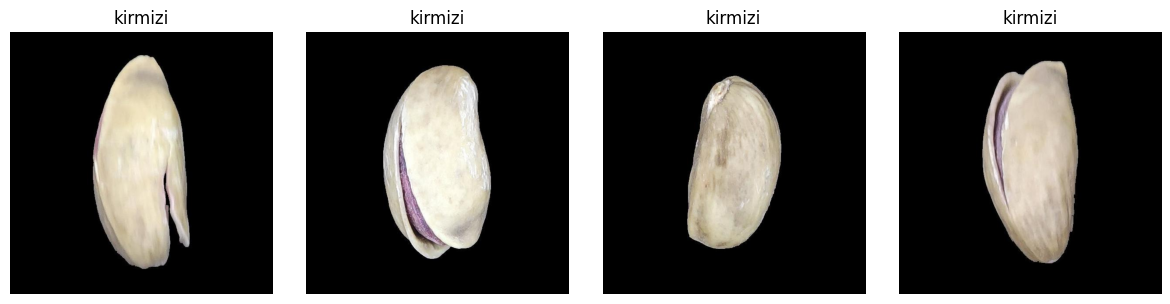

In [8]:
show_samples("kirmizi")

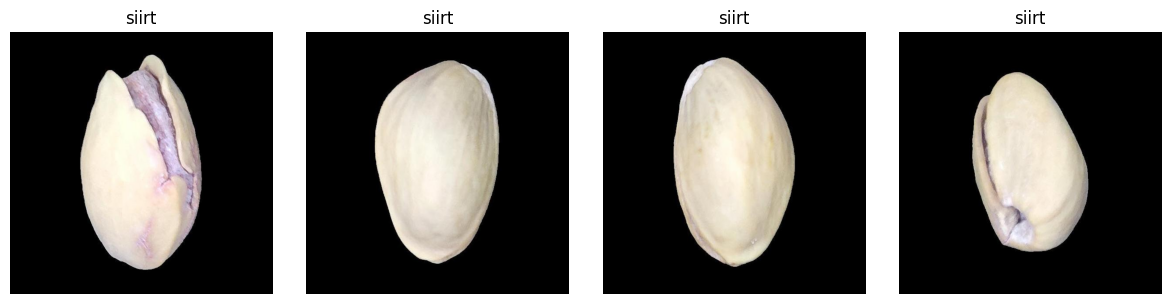

In [9]:
show_samples("siirt")

### Distribusi RGB dari Salah Satu Gambar

In [ ]:
example_path = df.iloc[0]["filepath"]
img = Image.open(example_path).resize((100, 100))
img_np = np.array(img)

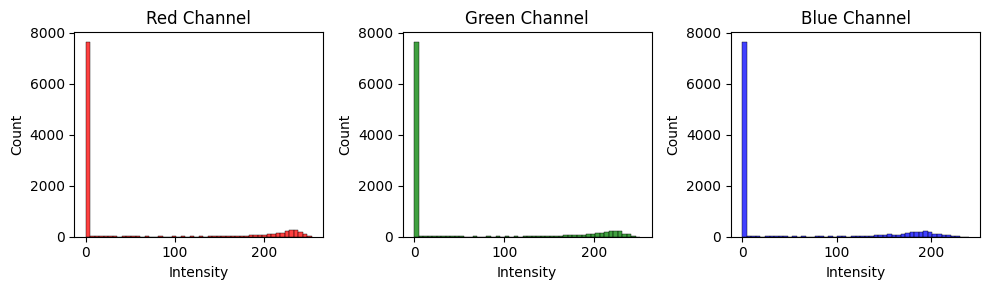

In [11]:
plt.figure(figsize=(10,3))
for i, color in enumerate(['Red', 'Green', 'Blue']):
    plt.subplot(1, 3, i+1)
    sns.histplot(img_np[..., i].flatten(), bins=50, color=color.lower())
    plt.title(f'{color} Channel')
    plt.xlabel('Intensity')
    # plt.xlim(0, 1)
plt.tight_layout()
plt.show()

Terlihat ada dua kelompok:
- Puncak tajam di intensitas rendah (~0) -> banyak bagian gambar berwarna gelap/hitam
- Puncak kecil di atas 200 -> bagian gambar yang cerah (objek terang)

### Statistik Nilai pixel Seluruh Dataset

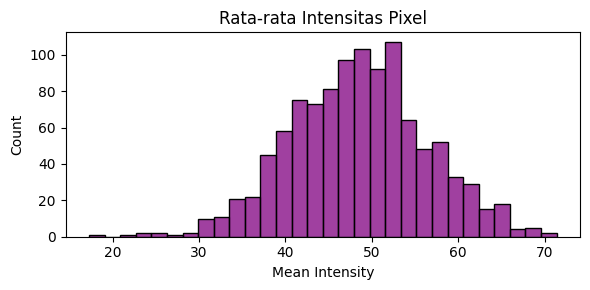

In [ ]:
# Hitung rata-rata intensitas pixel dari setiap gambar
pixel_means = []
for path in df["filepath"]:
    img = np.array(Image.open(path).resize((100, 100)))  # buka & resize gambar
    pixel_means.append(img.mean())  # simpan nilai rata-rata pixelnya)

plt.figure(figsize=(6,3))
sns.histplot(pixel_means, bins=30, color='purple')
plt.title("Rata-rata Intensitas Pixel")
plt.xlabel("Mean Intensity")
plt.tight_layout()
plt.show()

- Histogram menunjukkan sebaran nilai rata-rata intensitas pixel untuk seluruh gambar
- Nilai berada di kisaran 30–70, dengan puncak di sekitar 50
- Sebaran membentuk kurva seperti distribusi normal (bell-shape), artinya variasi pencahayaan antar gambar cukup konsisten

# B. Preprocessing

In [ ]:
# Jika nama file diawali dengan "kirmizi", label = 0; jika bukan (berarti "siirt"), label = 1
def extract_label(filename):
    return 0 if filename.split()[0].lower() == "kirmizi" else 1

# Buat daftar path lengkap untuk semua gambar dalam folder dataset
image_paths = [os.path.join(data_dir, f) for f in image_files]

# Gunakan fungsi extract_label untuk membuat daftar label numerik dari nama file
labels = [extract_label(f) for f in image_files]


### Resize dan Normalisasi

In [ ]:
# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(path):
    img = Image.open(path).resize((100, 100))  # resize ke 100x100
    img = np.array(img) / 255.0                # normalisasi nilai pixel ke 0–1
    return img.astype(np.float32)

print("Loading & processing images...")
images = np.array([load_and_preprocess_image(p) for p in image_paths])
labels = np.array(labels)
print(f"Loaded {len(images)} images, shape: {images.shape}")

Loading & processing images...
Loaded 1074 images, shape: (1074, 100, 100, 3)


- Total gambar yang berhasil diproses: 1074
- Ukuran tiap gambar: 100 x 100 pixel, dengan 3 channel warna (RGB)

### Splitting

In [ ]:
# Split data jadi 80% training dan 20% sisa (val + test)
train_img, test_img, train_lbl, test_lbl = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Split lagi 20% tadi jadi 10% val dan 10% test
val_img, test_img, val_lbl, test_lbl = train_test_split(
    test_img, test_lbl, test_size=0.5, stratify=test_lbl, random_state=42
)

print(f"Train: {len(train_img)}, Val: {len(val_img)}, Test: {len(test_img)}")

Train: 859, Val: 107, Test: 108


- Train (859 gambar): 80% dari total data, digunakan untuk melatih model
- Validation (107 gambar): 10%, digunakan untuk mengevaluasi performa selama pelatihan dan mencegah overfitting
- Test (108 gambar): 10%, digunakan untuk evaluasi akhir setelah model selesai dilatih

### Gaussian Noise

In [ ]:
# Fungsi untuk menambahkan noise Gaussian ke data gambar
def add_gaussian_noise(images, mean=0.0, stddev=0.1):
    noise = np.random.normal(loc=mean, scale=stddev, size=images.shape)  # buat noise dengan distribusi normal
    noisy_images = images + noise  # tambahkan noise ke gambar
    noisy_images = np.clip(noisy_images, 0.0, 1.0)  # jaga nilai tetap dalam rentang 0–1
    return noisy_images.astype(np.float32)  # pastikan tipe data sesuai untuk model

In [17]:
train_noisy = add_gaussian_noise(train_img)
val_noisy = add_gaussian_noise(val_img)
test_noisy = add_gaussian_noise(test_img)

### Prepare Dataset

In [ ]:
# Fungsi untuk membuat dataset TensorFlow dari gambar noisy dan gambar aslinya
def make_tf_dataset(noisy, clean, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((noisy, clean))  # pasangkan noisy dan clean image
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)  # acak dataset untuk training
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)  # batching & prefetch untuk efisiensi
    return ds

In [ ]:
train_ds = make_tf_dataset(train_noisy, train_img)
val_ds = make_tf_dataset(val_noisy, val_img, shuffle=False)
test_ds = make_tf_dataset(test_noisy, test_img, shuffle=False)

### Visualisasi Gambar Asli vs Noisy

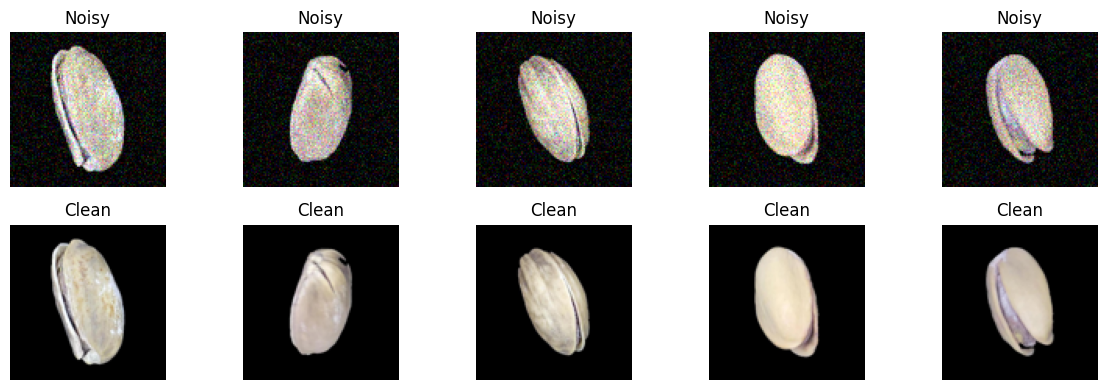

In [ ]:
# Fungsi untuk menampilkan gambar noisy dan clean secara berdampingan
def show_noisy_images(noisy, clean, n=5):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Gambar noisy di baris pertama
        plt.subplot(2, n, i+1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis("off")
        
        # Gambar asli (clean) di baris kedua
        plt.subplot(2, n, i+1+n)
        plt.imshow(clean[i])
        plt.title("Clean")
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

# Tampilkan 5 sampel gambar dari training set
show_noisy_images(train_noisy, train_img)

- Baris atas menunjukkan gambar yang sudah ditambahkan Gaussian noise (terlihat banyak titik-titik bintik acak)
- Baris bawah menunjukkan gambar asli (bersih) sebagai ground truth
- Visualisasi ini membantu memahami seberapa besar noise yang ditambahkan, dan bagaimana target autoencoder nantinya adalah memulihkan gambar noisy ke versi clean seperti ini

# Autoencoder

In [20]:
# Folder simpan bobot
save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Fungsi untuk mengatur callback yang akan digunakan saat training
def get_callbacks(filename, patience_early=5, patience_reduce=3):
    return [
        # Hentikan training lebih awal jika val_loss tidak membaik dalam beberapa epoch
        EarlyStopping(
            monitor='val_loss',              # pantau metrik val_loss
            patience=patience_early,         # hentikan jika tidak membaik selama x epoch
            restore_best_weights=True,       # kembalikan bobot terbaik
            verbose=1
        ),
        # Kurangi learning rate jika val_loss stagnan
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,                      # kurangi learning rate jadi setengah
            patience=patience_reduce,        # setelah stagnan x epoch
            verbose=1
        ),
        # Simpan bobot model terbaik selama training
        ModelCheckpoint(
            filepath=os.path.join("./checkpoints", filename),  # lokasi file simpan
            monitor='val_loss',
            save_best_only=True,             # hanya simpan jika lebih baik dari sebelumnya
            save_weights_only=True,          # hanya simpan bobot (tanpa arsitektur)
            verbose=1
        )
    ]

In [ ]:
def show_denoising_result(model, test_dataset, n=5):
    # Ambil 1 batch dari test_dataset (berisi pasangan: noisy dan clean image)
    for noisy_batch, clean_batch in test_dataset.take(1):
        # Gunakan model untuk memprediksi (denoise) gambar noisy
        pred_batch = model.predict(noisy_batch)

        # Siapkan figure dengan ukuran lebar sesuai jumlah gambar
        plt.figure(figsize=(n * 3, 6))

        for i in range(n):
            # Baris 1: Gambar dengan noise (input model)
            plt.subplot(3, n, i + 1)
            plt.imshow(noisy_batch[i])
            plt.title("Noisy")
            plt.axis('off')

            # Baris 2: Gambar hasil denoising oleh model
            plt.subplot(3, n, i + 1 + n)
            plt.imshow(pred_batch[i])
            plt.title("Denoised")
            plt.axis('off')

            # Baris 3: Gambar asli yang bersih (ground truth)
            plt.subplot(3, n, i + 1 + 2 * n)
            plt.imshow(clean_batch[i])
            plt.title("Clean")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

## C. Baseline

In [ ]:
autoencoder = Sequential([
    # Encoder
    InputLayer(input_shape=(100, 100, 3)),  # Input: gambar RGB 100x100
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Ekstraksi fitur awal
    MaxPooling2D((2, 2), padding='same'),                   # Downsampling → 50x50

    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Tambah kedalaman fitur
    MaxPooling2D((2, 2), padding='same'),                   # Downsampling → 25x25

    # Bottleneck
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Representasi kompresi fitur (bottleneck)

    # Decoder
    UpSampling2D((2, 2)),  # Upsampling → 50x50
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Perbaiki detail spasial
    UpSampling2D((2, 2)),  # Upsampling → 100x100

    Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # Output layer: kembalikan ke 3 channel RGB (0–1)
])

# Kompilasi model dengan optimizer Adam dan loss MSE
autoencoder.compile(optimizer=Adam(), loss='mse')

# Tampilkan arsitektur model
autoencoder.summary()

c:\Users\User\.conda\envs\deep_learning\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks_base = get_callbacks(
    filename="autoencoder_base.weights.h5"
    patience_early=5,
    patience_reduce=3
)

In [25]:
history_base = autoencoder.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks_base
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.1269
Epoch 1: val_loss improved from inf to 0.00918, saving model to ./checkpoints\autoencoder_base.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 270ms/step - loss: 0.1247 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.0072
Epoch 2: val_loss improved from 0.00918 to 0.00399, saving model to ./checkpoints\autoencoder_base.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 259ms/step - loss: 0.0072 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0038
Epoch 3: val_loss improved from 0.00399 to 0.00305, saving model to ./checkpoints\autoencoder_base.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - loss: 0.0038 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0030
Epoch 4: val_loss improved from 0.00305 to 0.00267, saving model to ./checkpoints\autoencoder_base.weights.h

##### **1. Fase Belajar Cepat (Epoch 1 - 17)**

Ini adalah fase di mana model membuat kemajuan paling besar. Log menunjukkan nilai `val_loss` turun secara signifikan dan konsisten, dari **0.00918** pada Epoch 1 hingga **0.00108** pada Epoch 17. Selama fase ini, model beroperasi dengan *learning rate* awal (0.001), memungkinkannya belajar dengan langkah besar dan cepat.

##### **2. Fase Penyempurnaan (Epoch 18 - 30)**

Fase ini dimulai secara jelas pada **Epoch 18**, di mana log pertama kali menunjukkan `ReduceLROnPlateau reducing learning rate`. Ini adalah titik balik di mana kemajuan mulai melambat dan proses optimasi yang lebih halus dimulai. Dari Epoch 18 hingga Epoch 30, *learning rate* diturunkan secara bertahap (menjadi 0.0005, 0.00025, dst.). Tujuannya adalah agar model dapat mencari solusi terbaik dengan lebih hati-hati dan presisi.

##### **3. Fase Pemolesan Akhir (Epoch 31 - 50)**

Ini adalah fase final di mana model melakukan optimasi dalam skala mikro. Perbaikan pada `val_loss` menjadi sangat kecil, seperti yang tercatat pada **Epoch 43**, di mana `val_loss` hanya turun dari 0.00090 menjadi 0.00089. *Learning rate* pada tahap ini sudah sangat rendah. Pada akhirnya, model mencapai `val_loss` terbaiknya yaitu **0.00089446** tepat pada **Epoch 50**, yang menunjukkan bahwa keseluruhan proses, termasuk pemolesan akhir ini, berhasil memandu model ke performa puncaknya.

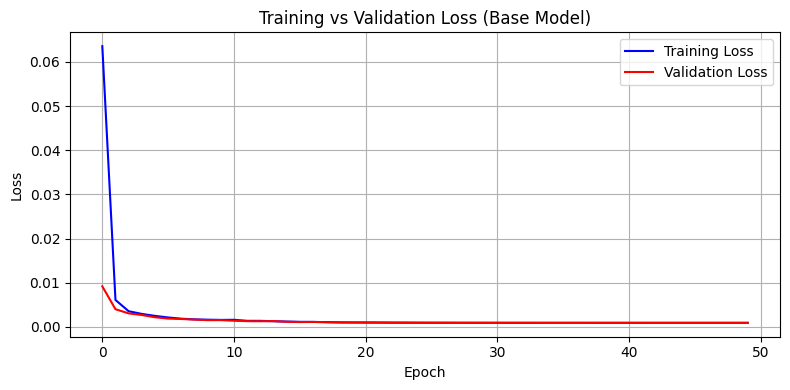

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(history_base.history['loss'], label='Training Loss', color='blue')
plt.plot(history_base.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (Base Model)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1.  **Penurunan Awal yang Cepat:** Pada awal training, nilai error (`Loss`) turun dengan sangat drastis. Ini artinya model mampu mempelajari pola-pola utama dari data dengan cepat.

2.  **Konvergensi dan Stabilitas:** Setelah penurunan awal, kurva `Training Loss` (biru) dan `Validation Loss` (merah) berjalan sangat berdekatan dan menjadi sangat landai. Ini menunjukkan dua hal penting:
    * **Model Stabil:** Tidak ada tanda-tanda *overfitting*. Ini dibuktikan karena kurva `Validation Loss` tidak menjauh atau mulai naik kembali. Artinya, model dapat diandalkan untuk data baru.
    * **Error Sangat Rendah:** Kedua kurva menjadi datar di posisi yang sangat dekat dengan angka nol. Ini menandakan model telah mencapai tingkat error yang sangat kecil dan performanya sudah optimal.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


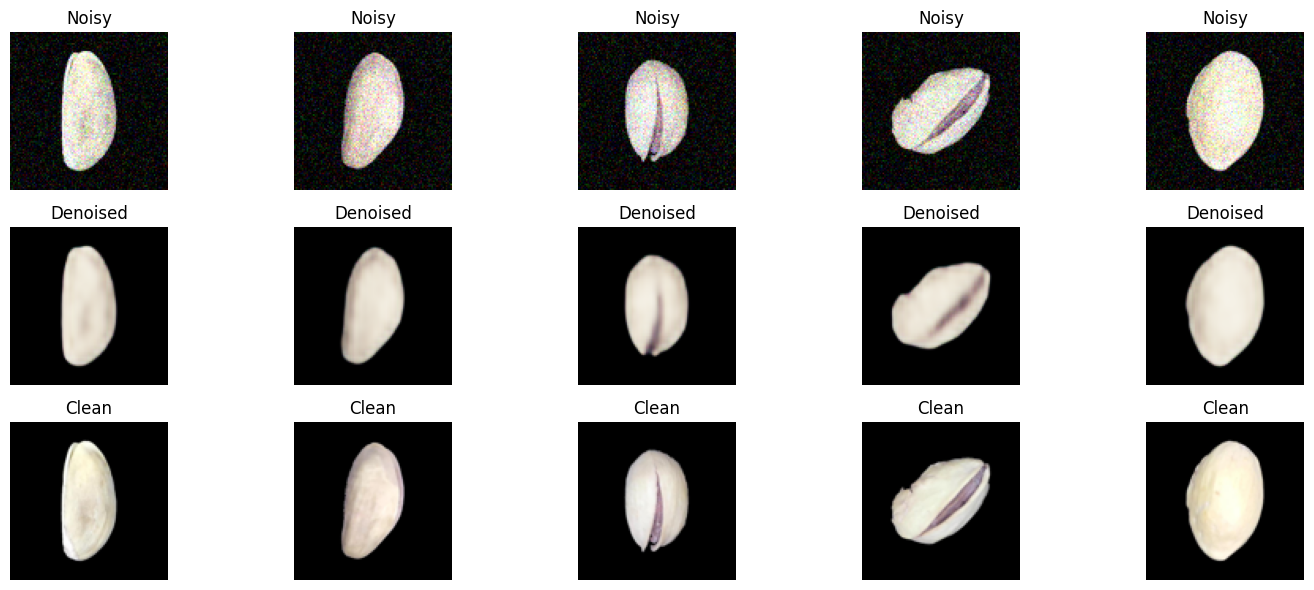

In [27]:
show_denoising_result(model=autoencoder, test_dataset=test_ds, n=5)

1. **Noise berhasil dikurangi** -> Autoencoder menghilangkan noise cukup baik
2. **Detail hilang** -> Hasil terlihat agak blur, beberapa fitur halus seperti tekstur dan garis tidak pulih sempurna
3. **Bentuk umum terjaga** -> Struktur biji tetap terlihat jelas
4. **Konsistensi warna dan pencahayaan** -> Warna output cukup stabil, tapi sedikit pucat

## D. Modified

**Dasar Perubahan Arsitektur dan Strategi Training**

1. **Penambahan Kapasitas Dekoder**

* **Masalah di baseline:** Decoder hanya memiliki satu `Conv2D(32)` setelah upsampling, yang terbatas dalam merekonstruksi detail visual dari bottleneck.
* **Perubahan di modifikasi:** Ditambahkan satu layer `Conv2D(64)` tambahan pada decoder.
* **Tujuan:** Memberikan model kapasitas lebih untuk menangkap dan mengembalikan informasi spasial dan tekstur dari gambar asli secara lebih akurat.

2. **Regularisasi dengan Dropout**

* **Masalah di baseline:** Tidak adanya regularisasi membuat model rentan overfitting, terutama pada noise tertentu yang bersifat spesifik.
* **Perubahan di modifikasi:** Disisipkan `Dropout(0.2)` setelah tahap encoding.
* **Tujuan:** Meningkatkan kemampuan generalisasi model dengan mencegah ketergantungan berlebih pada fitur tertentu dalam data pelatihan.

3. **Perubahan Fungsi Loss**

* **Baseline:** Menggunakan **Mean Squared Error (MSE)**, yang menilai kesalahan pixel-per-pixel tanpa mempertimbangkan struktur.
* **Modifikasi:** Mengganti menjadi **Binary Crossentropy (BCE)**.
* **Tujuan:** BCE secara empiris menghasilkan hasil visual yang lebih tajam dan menangani gambar yang ternormalisasi (0–1) dengan lebih baik, cocok untuk rekonstruksi detail visual.

4. **Optimasi Proses Training**

* **Learning Rate:** Pada baseline digunakan default Adam, sedangkan pada model modifikasi ditetapkan eksplisit `1e-3` untuk stabilitas awal pelatihan.
* **Callback:**

  * **Baseline**: `patience_early=5`, `patience_reduce=3`
  * **Modifikasi**: `patience_early=7`, `patience_reduce=4`
    -> Tujuan dari peningkatan patience adalah untuk memberi model modifikasi waktu yang cukup agar bisa memanfaatkan arsitektur yang lebih kompleks sebelum dihentikan.
* **Jumlah epoch ditingkatkan** dari 50 menjadi 75 untuk mengakomodasi arsitektur yang lebih dalam agar mencapai konvergensi optimal.


In [ ]:
autoencoder_modif = Sequential([
    InputLayer(input_shape=(100, 100, 3)),  # Input: gambar RGB ukuran 100x100

    # ENCODER
    Conv2D(32, (3, 3), activation='relu', padding='same'),        # Ekstraksi fitur awal
    MaxPooling2D((2, 2), padding='same'),                         # Downsampling → 50x50

    Conv2D(64, (3, 3), activation='relu', padding='same'),        # Tambahan kedalaman fitur
    MaxPooling2D((2, 2), padding='same'),                         # Downsampling → 25x25
    Dropout(0.2),                                                 # Regularisasi: cegah overfitting

    # BOTTLENECK
    Conv2D(64, (3, 3), activation='relu', padding='same'),        # Representasi terkompresi (bottleneck)

    # DECODER
    UpSampling2D((2, 2)),                                         # Upsampling → 50x50
    Conv2D(64, (3, 3), activation='relu', padding='same'),        # Tambah representasi fitur

    UpSampling2D((2, 2)),                                         # Upsampling → 100x100
    Conv2D(32, (3, 3), activation='relu', padding='same'),        # Rekonstruksi spasial

    Conv2D(3, (3, 3), activation='sigmoid', padding='same')       # Output layer: RGB dengan nilai [0, 1]
])

# Kompilasi model dengan Adam (lr=1e-3) dan binary crossentropy (lebih cocok untuk gambar ternormalisasi)
autoencoder_modif.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')

# Tampilkan arsitektur model
autoencoder_modif.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 100, 100, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,579 (439.76 KB)

 Trainable params: 112,579 (439.76 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
callbacks_modif = get_callbacks(
    filename="autoencoder_modif.weights.h5",
    patience_early=7,
    patience_reduce=4
)

In [30]:
history_modif = autoencoder_modif.fit(
    train_ds,
    validation_data=val_ds,
    epochs=75,
    callbacks=callbacks_modif
)

Epoch 1/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - loss: 0.4294
Epoch 1: val_loss improved from inf to 0.12374, saving model to ./checkpoints\autoencoder_modif.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 533ms/step - loss: 0.4234 - val_loss: 0.1237 - learning_rate: 0.0010
Epoch 2/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - loss: 0.1257
Epoch 2: val_loss improved from 0.12374 to 0.12220, saving model to ./checkpoints\autoencoder_modif.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 541ms/step - loss: 0.1257 - val_loss: 0.1222 - learning_rate: 0.0010
Epoch 3/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - loss: 0.1240
Epoch 3: val_loss improved from 0.12220 to 0.12115, saving model to ./checkpoints\autoencoder_modif.weights.h5
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 589ms/step - loss: 0.1240 - val_loss: 0.1211 - learning_rate: 0.0010
Epoch 4/75
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 0.1230
Epoch 4: val_loss improved from 0.12115 to 0.12042, saving model to ./checkpoints\autoencoder_modif.wei

##### **1. Fase Awal (Epoch 1 - 10)**

Fase ini menunjukkan laju pembelajaran yang lambat. Berbeda dengan model sebelumnya, penurunan `val_loss` tidak terlalu drastis, yaitu hanya dari **0.1237** (Epoch 1) menjadi **0.1168** (Epoch 10). Ini mengindikasikan bahwa sejak awal, model modifikasi ini kurang efektif dalam mempelajari data.

##### **2. Fase Stagnasi (Epoch 11 - 53)**

Ini adalah fase terpanjang di mana model menunjukkan kemajuan yang sangat minim. Perbaikan pada `val_loss` sangat kecil dan tidak konsisten. Penurunan *learning rate* pertama kali melalui `ReduceLROnPlateau` baru terjadi pada **Epoch 36**, jauh lebih lambat dari model sebelumnya. Ini menandakan model "terjebak" cukup lama sebelum mencoba strategi belajar yang lebih halus.

##### **3. Fase Akhir & *Early Stopping* (Epoch 54 - 61)**

Pada fase ini, pembelajaran model benar-benar berhenti.
* **Performa Terbaik:** Model mencapai `val_loss` terbaiknya, yaitu **0.11392**, pada **Epoch 54**.
* ***Early Stopping*:** Setelah Epoch 54, tidak ada lagi perbaikan yang tercatat. Akibatnya, mekanisme *early stopping* menghentikan proses training secara otomatis pada **Epoch 61**.
* **Hasil Akhir:** Log mengonfirmasi `Restoring model weights from the end of the best epoch: 54`. Ini berarti model yang disimpan adalah versi dari Epoch 54, bukan Epoch 61.

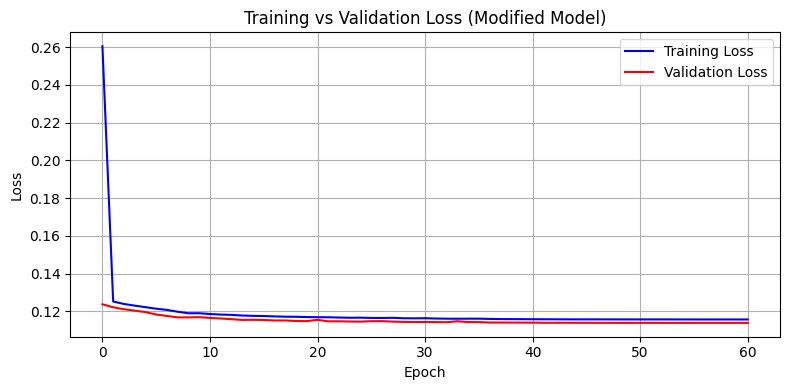

In [31]:
plt.figure(figsize=(8, 4))
plt.plot(history_modif.history['loss'], label='Training Loss', color='blue')
plt.plot(history_modif.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (Modified Model)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1.  **Penurunan Awal:** Pada awal training, kurva `Training Loss` (biru) turun sangat tajam dari nilai yang sangat tinggi (di atas 0.26), sementara `Validation Loss` (merah) memulai dari titik yang jauh lebih rendah (sekitar 0.12). Keduanya kemudian dengan cepat bertemu (konvergen).

2.  **Stagnasi Pembelajaran:** Setelah beberapa epoch awal, kedua kurva menjadi **sangat landai dan hampir mendatar**. Ini menandakan bahwa proses pembelajaran model melambat secara drastis dan model kesulitan untuk meningkatkan performanya lebih jauh, meskipun training dilanjutkan hingga 60 epoch.

3.  **Tingkat Error Akhir:** Secara visual, kurva berhenti di tingkat error yang relatif tinggi, yaitu di sekitar **0.114**. Nilai ini secara signifikan lebih tinggi dibandingkan hasil "Base Model" sebelumnya.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


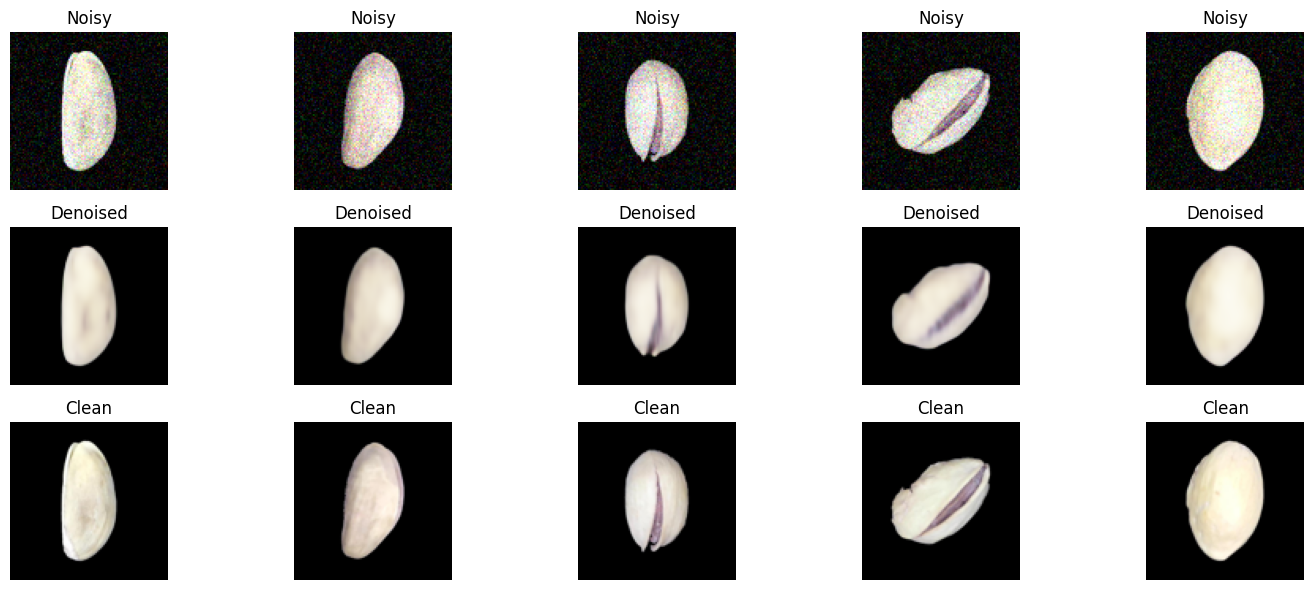

In [32]:
show_denoising_result(model=autoencoder_modif, test_dataset=test_ds, n=5)

1. **Noise lebih bersih** -> Model berhasil hilangkan noise dengan lebih efektif dibanding baseline
2. **Detail lebih tajam** -> Garis, lekukan, dan pola biji tampak lebih jelas dan tidak terlalu blur
3. **Bentuk tetap utuh** -> Bentuk biji tetap sama dengan gambar aslinya, tidak berubah atau rusak
4. **Warna lebih natural** -> Warna output mendekati warna asli, tidak pucat seperti di baseline

# E. Evaluation

In [ ]:
def evaluate_model_ssim(model, test_dataset):
    """
    Menghitung nilai SSIM antara hasil denoising model dengan ground truth.

    Args:
        model: Trained autoencoder model.
        test_dataset: tf.data.Dataset berisi (noisy, clean) images.

    Returns:
        List nilai SSIM per gambar.
    """
    all_noisy = []  # Menyimpan seluruh gambar noisy dari dataset
    all_clean = []  # Menyimpan seluruh gambar ground truth (bersih)

    # Looping seluruh batch dalam test_dataset
    for x_batch, y_batch in test_dataset:
        all_noisy.append(x_batch)
        all_clean.append(y_batch)

    # Gabungkan semua batch menjadi satu array besar
    all_noisy = tf.concat(all_noisy, axis=0)
    all_clean = tf.concat(all_clean, axis=0)

    # Lakukan prediksi (denoising) terhadap seluruh gambar noisy
    predictions = model.predict(all_noisy)

    # Hitung nilai SSIM untuk setiap pasangan prediksi dan ground truth
    scores = []
    for i in range(all_clean.shape[0]):
        score = ssim(
            all_clean[i].numpy(),     # Gambar ground truth
            predictions[i],           # Gambar hasil prediksi
            data_range=1.0,           # Rentang nilai pixel (karena gambar dinormalisasi)
            channel_axis=-1           # Menentukan bahwa channel warna ada di axis terakhir (RGB)
        )
        scores.append(score)

    return scores  # List nilai SSIM untuk seluruh gambar

**SSIM (Structural Similarity Index Measure)**

SSIM, atau *Structural Similarity Index Measure*, adalah sebuah metrik yang digunakan untuk mengukur tingkat kesamaan antara dua gambar digital. Tujuan utama metrik ini adalah untuk menyediakan hasil evaluasi kualitas yang lebih selaras dengan persepsi visual manusia.

**Prinsip Kerja**

Berbeda dengan metode konvensional yang hanya menghitung galat (error) matematis antar piksel, SSIM bekerja dengan cara membandingkan tiga aspek kunci dari sebuah gambar yang dianggap penting oleh sistem visual manusia.

**Tiga Komponen Evaluasi**

SSIM mengevaluasi kemiripan berdasarkan tiga komponen berikut:

1.  **Luminans (Luminance):** Membandingkan tingkat kecerahan rata-rata pada kedua gambar.
2.  **Kontras (Contrast):** Mengukur kesamaan rentang intensitas cahaya (gelap-terang) pada kedua gambar.
3.  **Struktur (Structure):** Menganalisis kemiripan pola dan susunan informasi struktural pada kedua gambar.

**Interpretasi Nilai**

Nilai atau skor SSIM umumnya berada pada rentang 0 hingga 1.

* **Nilai 1** menunjukkan bahwa kedua gambar identik secara sempurna.
* **Nilai yang mendekati 1** (misalnya, 0.97) menandakan tingkat kemiripan yang sangat tinggi.
* **Nilai yang mendekati 0** menandakan tingkat kemiripan yang sangat rendah.

**Fungsi dan Aplikasi**

Metrik SSIM memiliki fungsi penting dalam berbagai bidang, antara lain:

* **Evaluasi Kompresi:** Mengukur penurunan kualitas visual pada gambar atau video yang telah melalui proses kompresi.
* **Analisis gambar:** Digunakan dalam bidang medis untuk membandingkan hasil pindaian (scan) atau dalam sistem pengawasan untuk deteksi perubahan.
* **Penilaian Model AI:** Menjadi standar untuk menilai kualitas hasil dari model kecerdasan buatan yang bertugas merekonstruksi atau menghasilkan gambar baru.

In [34]:
def plot_ssim_distribution(ssim_scores):
    """
    Menampilkan histogram distribusi SSIM dan mencetak statistik ringkas.

    Args:
        ssim_scores (list or np.ndarray): List atau array nilai SSIM.
    """
    plt.figure(figsize=(8, 4))
    sns.histplot(ssim_scores, bins=30, kde=True, color='skyblue')
    plt.title("Distribusi Nilai SSIM pada Test Set")
    plt.xlabel("SSIM")
    plt.ylabel("Jumlah Gambar")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Statistik
    print(f"Rata-rata SSIM : {np.mean(ssim_scores):.4f}")
    print(f"Median SSIM    : {np.median(ssim_scores):.4f}")
    print(f"Minimum SSIM   : {np.min(ssim_scores):.4f}")
    print(f"Maksimum SSIM  : {np.max(ssim_scores):.4f}")


## Baseline

In [35]:
ssim_scores_base = evaluate_model_ssim(autoencoder, test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


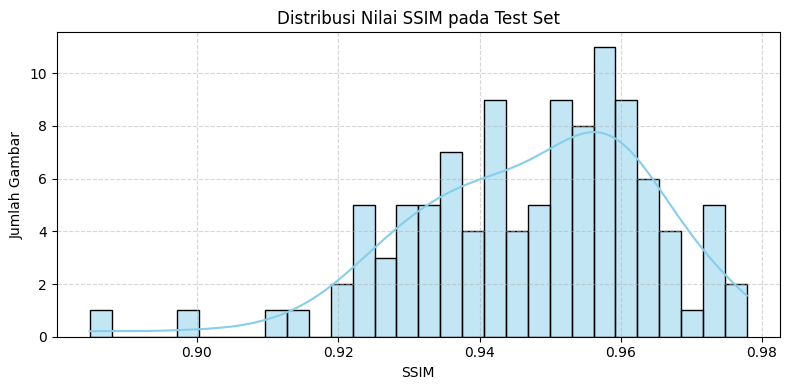

Rata-rata SSIM : 0.9473
Median SSIM    : 0.9502
Minimum SSIM   : 0.8848
Maksimum SSIM  : 0.9779


In [36]:
plot_ssim_distribution(ssim_scores_base)

##### **Distribusi SSIM:**

* **Rentang SSIM:** Nilai SSIM bervariasi dari **0.8848 hingga 0.9779**, menunjukkan bahwa semua gambar hasil denoising memiliki tingkat kemiripan struktural yang tinggi terhadap ground truth.
* **Mayoritas gambar berada pada rentang 0.93–0.96**, ditandai dengan puncak distribusi (mode) pada sekitar **0.955**.
* **Kurva distribusi simetris condong ke kanan**, menunjukkan sebagian besar gambar berada pada kualitas sangat tinggi, dengan hanya sedikit gambar memiliki nilai SSIM di bawah 0.91.

##### **Statistik Deskriptif SSIM:**

* **Rata-rata SSIM:** 0.9473
  Menunjukkan bahwa secara umum, gambar hasil prediksi memiliki struktur visual yang sangat dekat dengan gambar asli.
* **Median SSIM:** 0.9502
  Nilai tengah distribusi mendekati rata-rata, memperkuat kesimpulan bahwa sebaran performa model stabil dan tidak skewed secara ekstrem.
* **Minimum SSIM:** 0.8848
  Menandakan adanya beberapa sampel dengan struktur yang tidak sepenuhnya dipulihkan, namun masih dalam rentang layak.
* **Maksimum SSIM:** 0.9779
  Beberapa prediksi model hampir identik secara visual dengan gambar ground truth.

Model baseline menunjukkan **kinerja denoising yang konsisten dan stabil**, dengan distribusi nilai SSIM yang sempit dan rata-rata tinggi. Sebagian besar gambar berhasil direkonstruksi dengan akurasi struktural yang sangat baik, menandakan bahwa model memiliki kapabilitas generalisasi yang kuat terhadap data yang mengandung noise.

## Modified

In [37]:
ssim_scores_modif = evaluate_model_ssim(autoencoder_modif, test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step


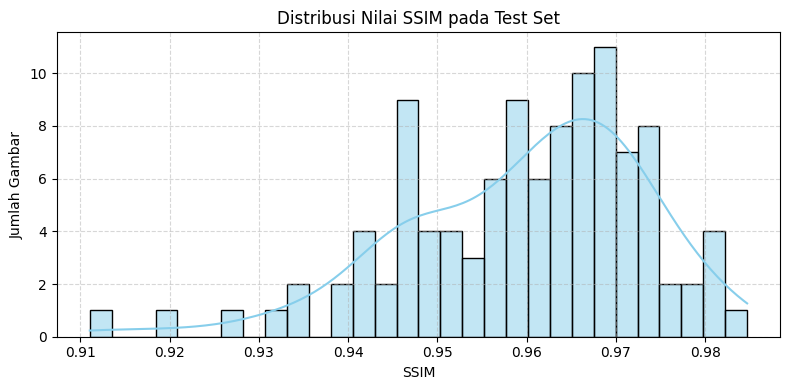

Rata-rata SSIM : 0.9597
Median SSIM    : 0.9621
Minimum SSIM   : 0.9111
Maksimum SSIM  : 0.9847


In [38]:
plot_ssim_distribution(ssim_scores_modif)

##### **Interpretasi Distribusi SSIM**

* Distribusi SSIM lebih terkonsentrasi di kisaran **0.95–0.98**, yang menunjukkan peningkatan performa dibanding model baseline.
* Puncak distribusi berada pada sekitar **0.97**, menandakan bahwa sebagian besar gambar hasil denoising memiliki kualitas sangat tinggi.
* Kurva KDE menunjukkan distribusi yang lebih tajam dan bergeser ke kanan, mengindikasikan **konsistensi dan akurasi yang lebih tinggi** dibanding model awal.

##### **Statistik SSIM**

* **Rata-rata SSIM:** 0.9597
  Mengalami peningkatan sebesar **+0.0124** dibanding model baseline (0.9473).
* **Median SSIM:** 0.9621
  Nilai tengah juga naik, mengindikasikan perbaikan menyeluruh, bukan hanya pada outlier.
* **Minimum SSIM:** 0.9111
  Nilai terendah meningkat dari sebelumnya 0.8848, menunjukkan bahwa **prediksi terburuk pun menjadi lebih baik**.
* **Maksimum SSIM:** 0.9847
  Lebih tinggi dari model baseline, menandakan adanya prediksi yang hampir identik dengan ground truth.

Model modifikasi menunjukkan **peningkatan performa yang signifikan dan konsisten** dalam proses denoising. Peningkatan ini tercermin dari distribusi nilai SSIM yang bergeser ke kanan, serta nilai statistik yang lebih tinggi pada seluruh metrik evaluasi. Oleh karena itu, dapat disimpulkan bahwa **model modifikasi lebih unggul dibandingkan model baseline** dalam merekonstruksi gambar bersih dari input yang mengandung noise.


## Arsitektur dan Pengaruhnya terhadap Kualitas Denoising

#### 1. **Model Baseline**

Arsitektur:

Model baseline menggunakan arsitektur autoencoder dasar dengan:

* Dua blok **encoder**: `Conv2D + MaxPooling2D`
* Satu **bottleneck** layer (Conv2D 64 filter)
* Dua blok **decoder**: `UpSampling2D + Conv2D`
* Output layer `Conv2D(3)` dengan aktivasi `sigmoid` untuk menghasilkan gambar RGB

Hyperparameter:

* **Loss function**: MSE
* **Optimizer**: Adam (default learning rate)
* **Callback**:

  * EarlyStopping (patience = 5)
  * ReduceLROnPlateau (patience = 3)
  * ModelCheckpoint

Evaluasi Kinerja:

* **Rata-rata SSIM**: 0.9473
* **Distribusi SSIM** cukup merata, namun menyisakan beberapa outlier rendah (min SSIM = 0.8848)
* Kurva KDE menunjukkan konsistensi, tetapi performa belum optimal

Struktur model yang sederhana dan jumlah filter decoder yang lebih rendah (32) kemungkinan menyebabkan kapasitas rekonstruksi terbatas, terutama dalam mengembalikan detail halus dari gambar asli. Selain itu, **penggunaan MSE** cenderung menghukum kesalahan pixel secara rata, tanpa mempertimbangkan struktur visual, sehingga hasil rekonstruksi cenderung lebih kabur.

#### 2. **Model Modifikasi**

Perubahan Kunci:

* Penambahan **Dropout (0.2)** setelah layer encoder -> mencegah overfitting dan membantu generalisasi
* Penambahan satu layer `Conv2D(64)` di decoder -> meningkatkan **kapasitas pemulihan detail visual**
* **Loss function diubah** menjadi `binary_crossentropy` -> cenderung memberi hasil visual lebih tajam
* **Learning rate eksplisit**: Adam(1e-3)
* **Patience callback lebih tinggi** -> memberi waktu model untuk belajar lebih lama

Evaluasi Kinerja:

* **Rata-rata SSIM meningkat** ke 0.9597 (+0.0124 dari baseline)
* **Minimum SSIM juga meningkat** signifikan ke 0.9111 -> hasil buruk jadi lebih baik
* Distribusi SSIM **bergeser ke kanan dan lebih terpusat di nilai tinggi** -> peningkatan konsistensi dan kualitas global

Perubahan pada arsitektur dan konfigurasi pelatihan secara langsung meningkatkan performa model:

* Layer tambahan pada decoder membantu pemulihan informasi spasial
* Dropout menurunkan risiko overfitting, memungkinkan generalisasi lebih baik ke gambar uji
* `Binary crossentropy` sebagai loss lebih sensitif terhadap bentuk dan kontur dibanding MSE, cocok untuk rekonstruksi visual

# Kesimpulan

Model modifikasi menunjukkan **peningkatan kinerja yang signifikan**, sebagaimana ditunjukkan oleh statistik SSIM dan visualisasi distribusinya. Hal ini secara langsung terkait dengan:

* **Penambahan kapasitas representasi** (layer tambahan di decoder),
* **Penggunaan regularisasi** (Dropout),
* **Loss function yang lebih sesuai**, serta
* **Konfigurasi callback yang lebih fleksibel** untuk proses pembelajaran yang lebih stabil.

Model ini lebih mampu **merepresentasikan struktur visual** gambar dan menghasilkan hasil denoising yang **lebih tajam, bersih, dan konsisten** dibanding model baseline.